In [2]:

# This is lzl's snippet for diploma project
import math
import os,shutil
import random
import warnings
import gc

import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
import seaborn as sns
from shapely.geometry import LineString, Point, Polygon
from shapely.wkt import dumps, loads
from tqdm import tqdm

import traProject as tp
from traProject.analysisFuns import statisticFuns as sfuns
from traProject.basicFuns import CalFuns as cfun,VisFuns as vfun,DataProcessingFuns as dfun
from traProject.classificationFuns import models
import traProject.utils as tu

random.seed(1229)

# plt.style.use('seaborn')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

warnings.filterwarnings("ignore")

picOut='../../output/pic/paper/'


# 速度使用

In [49]:
path0='../../output/paper/样本路段_按link_id_v1/maxspeed=50/'
path1=tu.getFilesBySize(path0)
i=0
print(path1[i])
data=pd.read_csv(path1[i])
data

../../output/paper/样本路段_按link_id_v1/maxspeed=50/maxspeed=50_最大_352078086-0.csv


,pid,tid,roadid,fid,lon,lat,timestamp,speed,type,acc,bearing,heading,hour,month,day,velocity
0,9,662,352078086,271,114.345684,30.523524,1564136217,24.151200,0,8,196.0,1,18,7,26,24.151200
1,10,662,352078086,271,114.345266,30.521705,1564136304,8.541492,0,8,186.0,1,18,7,26,8.541492
2,11,662,352078086,271,114.345010,30.519948,1564136368,11.088169,0,6,179.0,1,18,7,26,11.088169
3,12,662,352078086,271,114.344819,30.518087,1564136436,11.010372,0,3,186.0,1,18,7,26,11.010372
4,13,662,352078086,271,114.344804,30.517926,1564136441,12.945672,0,3,185.0,1,18,7,26,12.945672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14396,11,2057,352078086,1848448,114.345610,30.523246,1564125694,48.093480,0,10,198.0,1,15,7,26,48.093480
14397,12,2057,352078086,1848448,114.345264,30.521698,1564125732,16.625151,0,5,191.0,1,15,7,26,16.625151
14398,13,2057,352078086,1848448,114.345003,30.519871,1564125783,14.464588,0,6,183.0,1,15,7,26,14.464588
14399,14,2057,352078086,1848448,114.344814,30.518037,1564125871,8.384846,0,4,184.0,1,15,7,26,8.384846


## 是否保留Wi-Fi

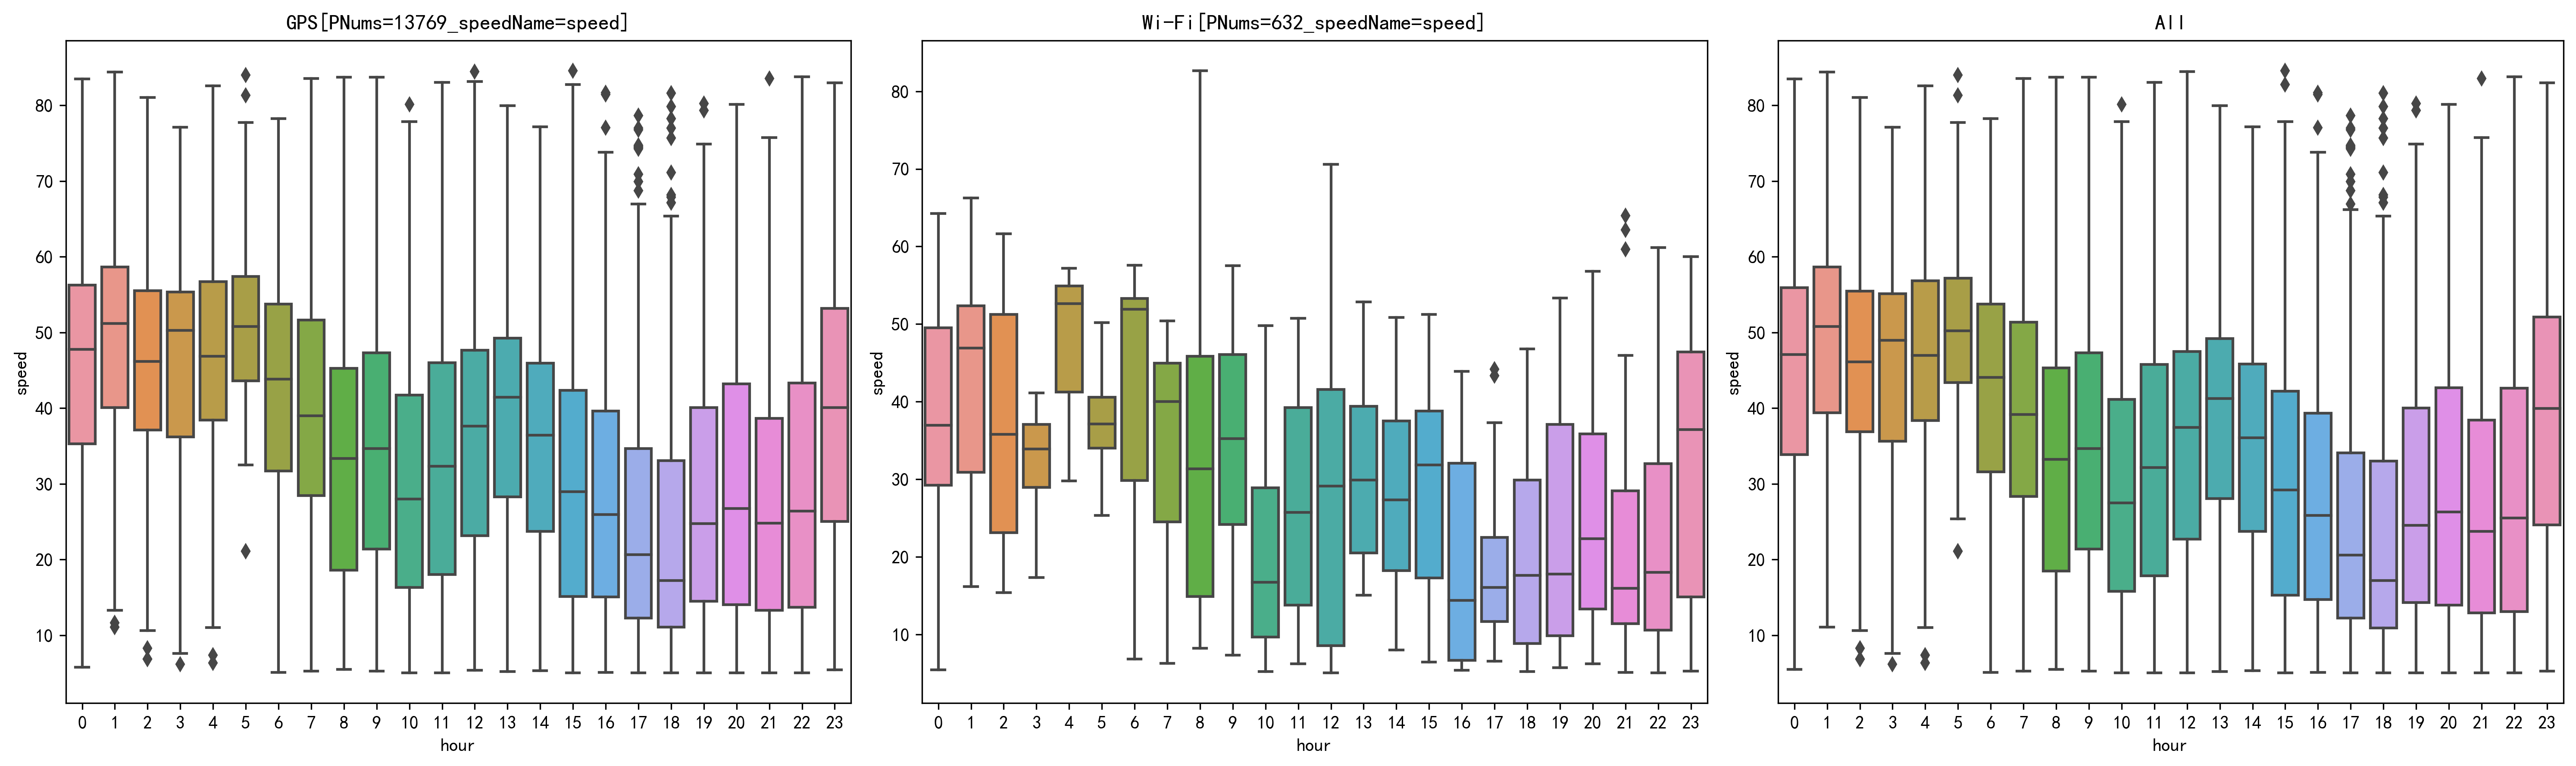

In [50]:
def keepWiFiOrNot(data,speedNameList=['speed']):
    gs=data.groupby('type')
    fig,ax=plt.subplots(1,3,figsize=[20,6],dpi=300)
    for i,speedName in enumerate(speedNameList):
        for name,g in gs:
            idx=int(name)
            n='GPS'if int(name)==0 else 'Wi-Fi'
            n+='[PNums=%s_speedName=%s]'%(len(g),speedName)
            sns.boxplot(g['hour'],g[speedName],ax=ax[idx])
            ax[idx].set_title(n)
        sns.boxplot(data['hour'],data[speedName],ax=ax[-1])
        ax[-1].set_title('All')
    plt.tight_layout(pad=1)
keepWiFiOrNot(data)
plt.savefig(picOut+'是否筛选Wi-Fi点')

## 以轨迹段为单位计算速度

../../output/paper/样本路段_按link_id_v3/maxspeed=40/maxspeed=40_最大_99480657-3.csv


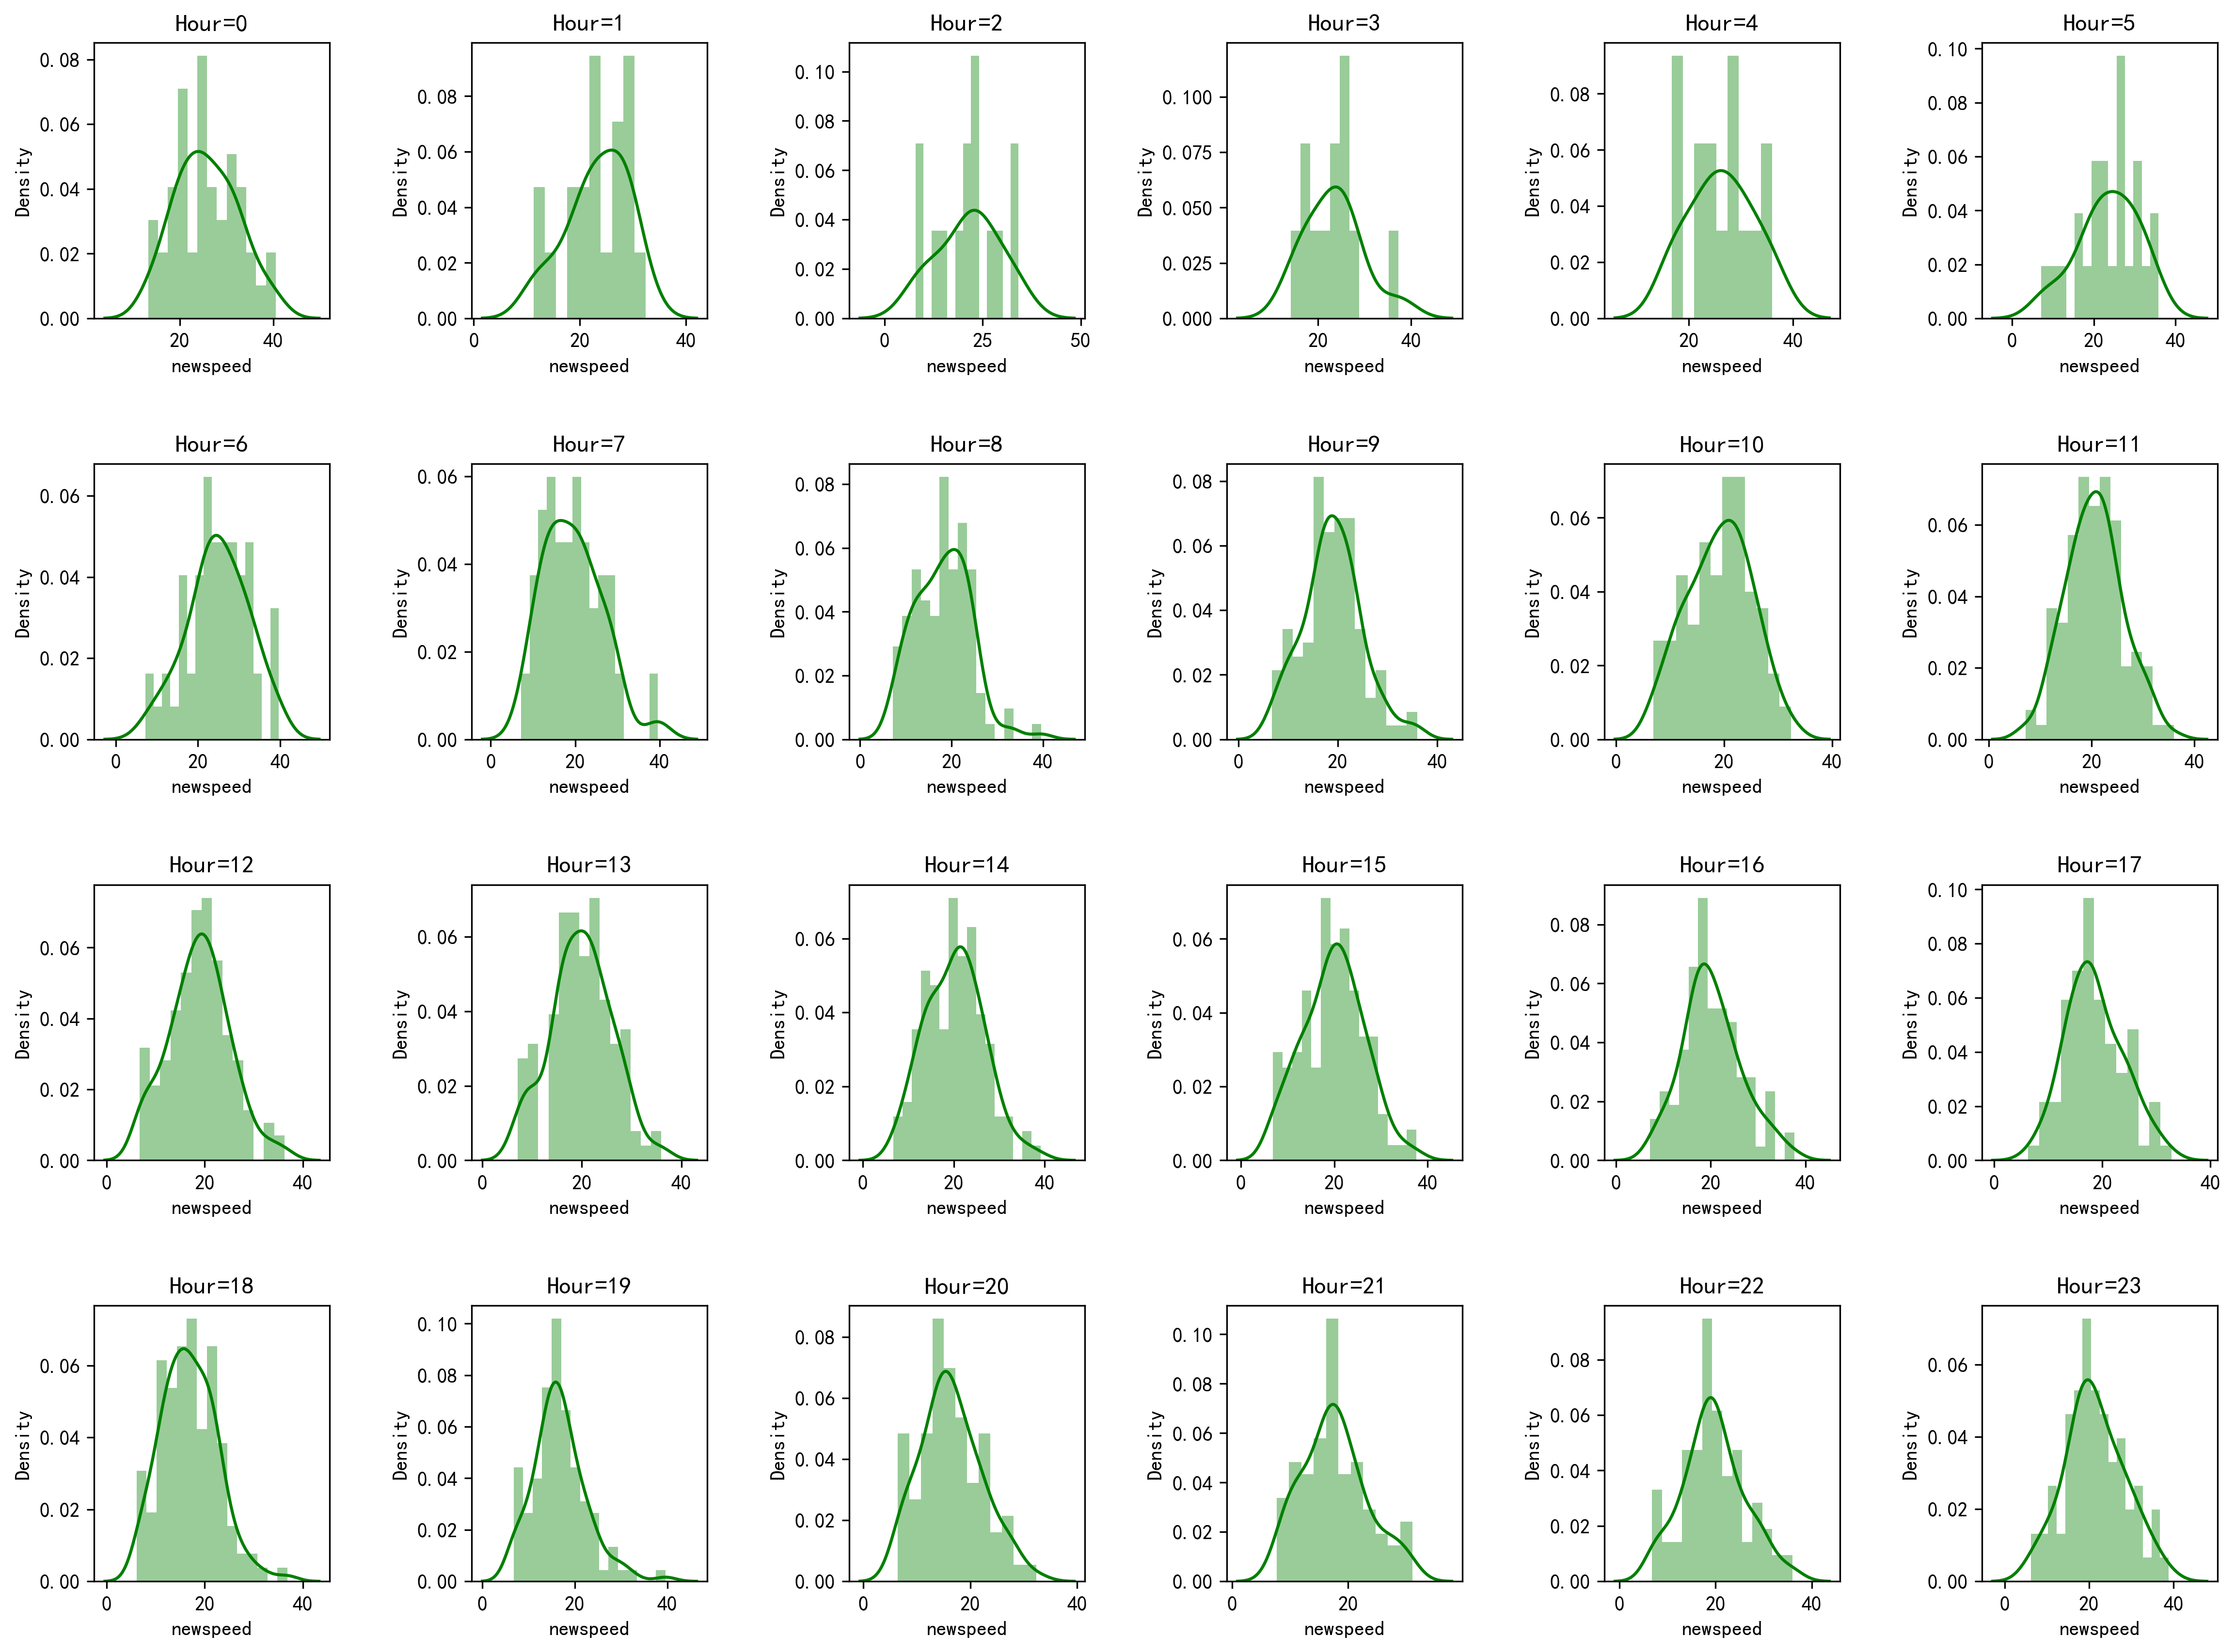

In [52]:
path0='../../output/paper/样本路段_按link_id_v3/'
path1=tu.getFileNames(path0)
i=2
path2=tu.getFilesBySize(path1[i]+'/')
j=0
print(path2[j])
data=pd.read_csv(path2[j])
vfun.visV_24h(data)
plt.savefig(picOut+'以轨迹段为单位')

## 高峰时段与低峰时段的关系

In [30]:
path0='../../output/paper/轨迹_按link_id_v2/'

prefix=path0.split('/')[-2]
path1=tu.scan_files(path0)
plt.figure(dpi=300)
for p in tqdm(path1):
    title=p.replace('\\',',link_id=').split('/')[-1].split('.csv')[0]
    maxspeed=int(title.split(',')[0].split('maxspeed=')[1])
    data=pd.read_csv(p)
    y=data.groupby('hour').speed.mean()
    plt.bar(y.index,y)
    plt.axhline(y=maxspeed,ls=":",c="red")
    plt.title(title)
    plt.xlabel('时间/小时')
    plt.ylabel('速度/(km/h)')
    plt.savefig(tu.pathCheck(picOut+'路段24h平均速度分布情况_%s/'%prefix)+title)
    plt.clf()

100%|████████████████████████████████████████████████████████████████████████████████| 3074/3074 [10:27<00:00,  4.90it/s]


<Figure size 1800x1200 with 0 Axes>

## 有效特征

In [4]:
path=tu.getSample('../../output/paper/轨迹_按link_id_v2_Pts_minN=50_bufR=1e-05_dropWifi=False_velocity=velocity1/')

In [5]:
path

'../../output/paper/样本路段/按link_id_v2_Pts_minN=50_bufR=1e-05_dropWifi=False_velocity=velocity1/'